# Scraping Data

In [1]:
!pip install google-play-scraper

In [2]:
from google_play_scraper import Sort, reviews
import pandas as pd

In [3]:
result = reviews(
    'com.gojek.gopay',
    lang='id',
    country='id',
    sort=Sort.MOST_RELEVANT,
    count=7000
)

In [4]:
result = pd.DataFrame(result[0])
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              7000 non-null   object        
 1   userName              7000 non-null   object        
 2   userImage             7000 non-null   object        
 3   content               7000 non-null   object        
 4   score                 7000 non-null   int64         
 5   thumbsUpCount         7000 non-null   int64         
 6   reviewCreatedVersion  6920 non-null   object        
 7   at                    7000 non-null   datetime64[ns]
 8   replyContent          4524 non-null   object        
 9   repliedAt             4524 non-null   datetime64[ns]
 10  appVersion            6920 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 601.7+ KB


In [5]:
data = result.to_csv('result.csv', index=False)

# Data Cleaning

In [6]:
data = pd.read_csv('result.csv')
data = data.drop(['reviewId','userName', 'userImage', 'reviewCreatedVersion', 'replyContent', 'repliedAt'],axis=1)

In [7]:
data = data.drop_duplicates()
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6920 entries, 0 to 6999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   content        6920 non-null   object
 1   score          6920 non-null   int64 
 2   thumbsUpCount  6920 non-null   int64 
 3   at             6920 non-null   object
 4   appVersion     6920 non-null   object
dtypes: int64(2), object(3)
memory usage: 324.4+ KB


In [8]:
data['at'] = pd.to_datetime(data['at'])
data = data[data['at'].dt.year == 2025]

data['month'] = data['at'].dt.month.astype('str')
data = data.drop(columns=['at'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6920 entries, 0 to 6999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   content        6920 non-null   object
 1   score          6920 non-null   int64 
 2   thumbsUpCount  6920 non-null   int64 
 3   appVersion     6920 non-null   object
 4   month          6920 non-null   object
dtypes: int64(2), object(3)
memory usage: 324.4+ KB


In [9]:
data.head()

,content,score,thumbsUpCount,appVersion,month
0,aplikasi nya udh bagus seperti yang lainnya ta...,2,18,1.56.1,8
1,Saya download aplikasi ini dan saat masukan no...,1,73,1.56.1,8
2,aplikasi gopay ini bagus tapi saat mau membaya...,2,10,1.56.1,8
3,"aplikasinya bagus aja, cuma ad sedikit masalah...",3,24,1.56.1,8
4,Cukup kecewa update kali ini. Mengapa sistem b...,2,18,1.56.1,8


In [10]:
print(data['appVersion'].unique())

['1.56.1' '1.53.0' '1.57.0' '1.52.0' '1.54.0' '1.51.0' '1.49.1' '1.49.0'
 '1.48.0' '1.45.0' '1.47.0' '1.46.1' '1.44.0' '1.56.0' '1.39.0' '1.26.1'
 '1.15.1' '1.21.0' '1.27.0']


In [11]:
data['minorVersion'] = data['appVersion']
data = data.drop(columns=['appVersion'], axis=1)
data['majorVersion'] = data['minorVersion'].str[:3]
data.head()

,content,score,thumbsUpCount,month,minorVersion,majorVersion
0,aplikasi nya udh bagus seperti yang lainnya ta...,2,18,8,1.56.1,1.5
1,Saya download aplikasi ini dan saat masukan no...,1,73,8,1.56.1,1.5
2,aplikasi gopay ini bagus tapi saat mau membaya...,2,10,8,1.56.1,1.5
3,"aplikasinya bagus aja, cuma ad sedikit masalah...",3,24,8,1.56.1,1.5
4,Cukup kecewa update kali ini. Mengapa sistem b...,2,18,8,1.56.1,1.5


In [12]:
print(data['majorVersion'].unique())

['1.5' '1.4' '1.3' '1.2' '1.1']


# Exploratory Data Analysis

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
data.describe()

,score,thumbsUpCount
count,6920.000000,6920.000000
mean,2.620231,6.484104
std,1.781047,32.636918
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,5.000000,2.000000
max,5.000000,1419.000000


<Axes: xlabel='score', ylabel='count'>

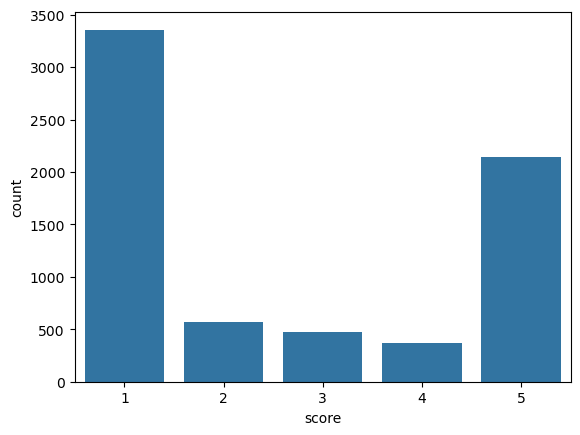

In [15]:
sns.countplot(data=data, x='score')

<Axes: xlabel='month', ylabel='count'>

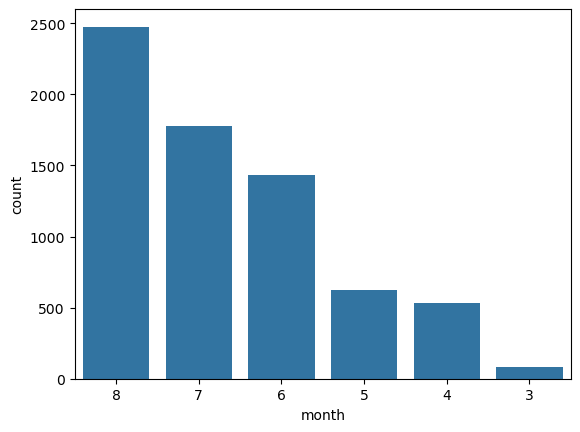

In [16]:
sns.countplot(data=data, x='month')

<Axes: xlabel='majorVersion', ylabel='count'>

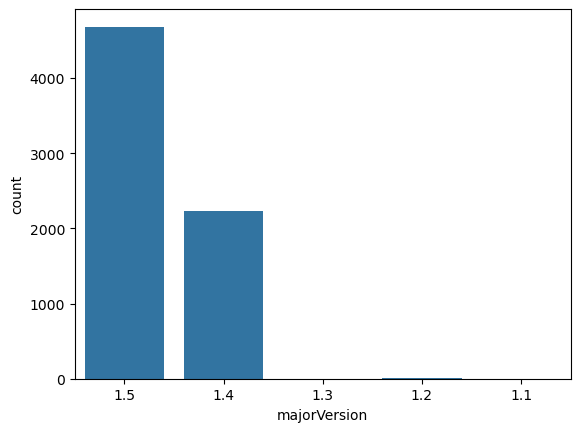

In [17]:
sns.countplot(data=data, x='majorVersion')

<Axes: xlabel='score', ylabel='thumbsUpCount'>

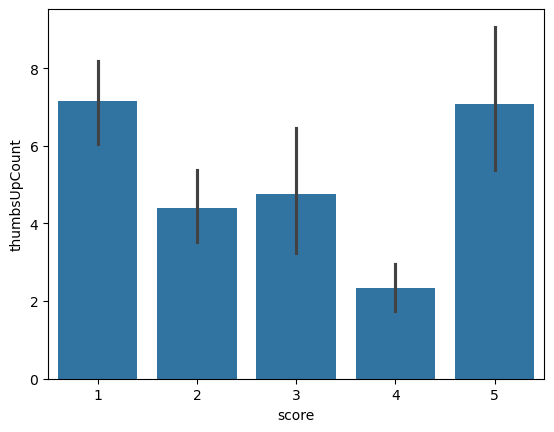

In [18]:
sns.barplot(data=data, x='score', y='thumbsUpCount')

<Axes: xlabel='majorVersion', ylabel='score'>

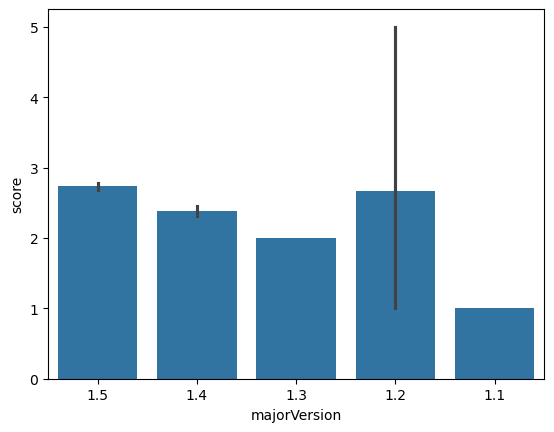

In [19]:
sns.barplot(data=data, x='majorVersion', y='score')

<Axes: xlabel='month', ylabel='Count'>

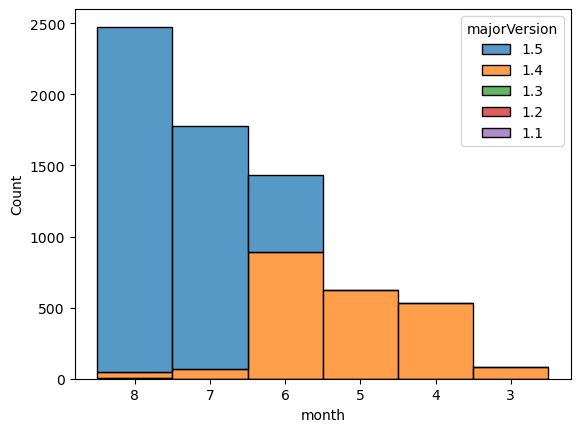

In [20]:
sns.histplot(data=data, x='month', hue='majorVersion', multiple="stack")

In [21]:
data.pivot_table(index='majorVersion',
                columns='month',
                values='score',
                aggfunc='mean')

month,3,4,5,6,7,8
majorVersion,,,,,,
1.1,NaN,NaN,NaN,NaN,NaN,1.000000
1.2,NaN,NaN,5.00000,1.000000,NaN,2.000000
1.3,NaN,NaN,NaN,NaN,2.000000,NaN
1.4,2.101266,2.443396,2.36715,2.335586,2.724638,3.022222
1.5,NaN,NaN,NaN,2.157509,2.728496,2.862850


# Sentiment Analysis

In [49]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.2/539.2 kB 55.3 MB/s eta 0:00:00


In [22]:
!pip install tqdm

In [23]:
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.0/802.0 kB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nltk]1/2 [nltk]


In [29]:
!pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [50]:
import re
import string
from tqdm import tqdm
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import pipeline
tqdm.pandas()
import asyncio
import time
import transformers
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [31]:
translator = pipeline(
    "translation",
    model="facebook/nllb-200-distilled-600M",
    src_lang="ind_Latn",
    tgt_lang="eng_Latn"
)

pipe = pipeline("text-classification", model="siebert/sentiment-roberta-large-english")

Device set to use cuda:0
Device set to use cuda:0


In [32]:
def translate(text):
  return translator(text)[0]["translation_text"]

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizing(text):
  tokens = word_tokenize(text)
  return tokens

def stopwordstext(text):
  stop_words = set(stopwords.words('english'))
  filtered_tokens = [word for word in text if word not in stop_words]
  return filtered_tokens

def lemitizing(text):
  lemmatizer = WordNetLemmatizer()
  processed_text = [lemmatizer.lemmatize(word) for word in text]
  processed_text = " ".join(processed_text)
  return processed_text

def sentimenttext(text):
  result = pipe(text)
  return result[0]['label']

In [33]:
docs = pd.DataFrame(data['content'].reset_index(drop=True), columns=['content'])

docs['text_translate'] = docs['content'].progress_apply(translate)
docs['text_clean'] = docs['text_translate'].progress_apply(cleaningText)
docs['text_lower'] = docs['text_clean'].progress_apply(casefoldingText)
docs['text_tokenizing'] = docs['text_lower'].progress_apply(tokenizing)
docs['text_stopwords'] = docs['text_tokenizing'].progress_apply(stopwordstext)
docs['text_lemitizing'] = docs['text_stopwords'].progress_apply(lemitizing)
docs['text_label'] = docs['text_lemitizing'].progress_apply(sentimenttext)

 45% 3114/6920 [10:00<08:36,  7.36it/s]Your input_length: 183 is bigger than 0.9 * max_length: 200. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
 52% 3632/6920 [11:54<08:50,  6.20it/s]Your input_length: 228 is bigger than 0.9 * max_length: 200. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
100% 6920/6920 [19:36<00:00,  5.88it/s]
100% 6920/6920 [00:00<00:00, 174867.96it/s]
100% 6920/6920 [00:00<00:00, 3828595.66it/s]
100% 6920/6920 [00:00<00:00, 37412.99it/s]
100% 6920/6920 [00:00<00:00, 46421.43it/s]
100% 6920/6920 [00:01<00:00, 6507.93it/s]
100% 6920/6920 [00:23<00:00, 289.10it/s]


In [34]:
docs

,content,text_translate,text_clean,text_lower,text_tokenizing,text_stopwords,text_lemitizing,text_label
0,aplikasi nya udh bagus seperti yang lainnya ta...,"The app is just as good as the others, but the...",The app is just as good as the others but ther...,the app is just as good as the others but ther...,"[the, app, is, just, as, good, as, the, others...","[app, good, others, theres, lot, weirdness, li...",app good others there lot weirdness like spin ...,NEGATIVE
1,Saya download aplikasi ini dan saat masukan no...,I downloaded this app and when I entered the n...,I downloaded this app and when I entered the n...,i downloaded this app and when i entered the n...,"[i, downloaded, this, app, and, when, i, enter...","[downloaded, app, entered, number, otp, code, ...",downloaded app entered number otp code worked ...,NEGATIVE
2,aplikasi gopay ini bagus tapi saat mau membaya...,"This gopay app is great, but when I want to pa...",This gopay app is great but when I want to pay...,this gopay app is great but when i want to pay...,"[this, gopay, app, is, great, but, when, i, wa...","[gopay, app, great, want, pay, transaction, th...",gopay app great want pay transaction there pro...,POSITIVE
3,"aplikasinya bagus aja, cuma ad sedikit masalah...","It's a good app, but it's just a little bit of...",Its a good app but its just a little bit of a ...,its a good app but its just a little bit of a ...,"[its, a, good, app, but, its, just, a, little,...","[good, app, little, bit, problem, trying, pay,...",good app little bit problem trying pay topup g...,POSITIVE
4,Cukup kecewa update kali ini. Mengapa sistem b...,I'm pretty disappointed with the update this t...,Im pretty disappointed with the update this ti...,im pretty disappointed with the update this ti...,"[im, pretty, disappointed, with, the, update, ...","[im, pretty, disappointed, update, time, curre...",im pretty disappointed update time current gop...,NEGATIVE
...,...,...,...,...,...,...,...,...
6915,ini gopay kenapa? apakah ganguan atau sudah ga...,is this gopay why? is it ganguan or is it no l...,is this gopay why is it ganguan or is it no lo...,is this gopay why is it ganguan or is it no lo...,"[is, this, gopay, why, is, it, ganguan, or, is...","[gopay, ganguan, longer, working, tokopedia, p...",gopay ganguan longer working tokopedia paylate...,NEGATIVE
6916,cepat & bagus... bonus nya banyak in.....,Fast & good... the bonus is a lot in...,Fast good the bonus is a lot in,fast good the bonus is a lot in,"[fast, good, the, bonus, is, a, lot, in]","[fast, good, bonus, lot]",fast good bonus lot,POSITIVE
6917,"gopay bagus teransaksi bebas kemana ajah, saya...",It's good to be free wherever you go. It's ver...,Its good to be free wherever you go Its very c...,its good to be free wherever you go its very c...,"[its, good, to, be, free, wherever, you, go, i...","[good, free, wherever, go, convenient]",good free wherever go convenient,POSITIVE
6918,Ini kenapa sy transfer ke teman saya saldo nya...,That's why I transfer to my friend the balance...,Thats why I transfer to my friend the balance ...,thats why i transfer to my friend the balance ...,"[thats, why, i, transfer, to, my, friend, the,...","[thats, transfer, friend, balance, hasnt, logg...",thats transfer friend balance hasnt logged con...,NEGATIVE


In [35]:
data = data.reset_index(drop=True)
docs = docs.reset_index(drop=True)
data['labels'] = docs['text_label']
data.head()

,content,score,thumbsUpCount,month,minorVersion,majorVersion,labels
0,aplikasi nya udh bagus seperti yang lainnya ta...,2,18,8,1.56.1,1.5,NEGATIVE
1,Saya download aplikasi ini dan saat masukan no...,1,73,8,1.56.1,1.5,NEGATIVE
2,aplikasi gopay ini bagus tapi saat mau membaya...,2,10,8,1.56.1,1.5,POSITIVE
3,"aplikasinya bagus aja, cuma ad sedikit masalah...",3,24,8,1.56.1,1.5,POSITIVE
4,Cukup kecewa update kali ini. Mengapa sistem b...,2,18,8,1.56.1,1.5,NEGATIVE


<Axes: xlabel='labels', ylabel='count'>

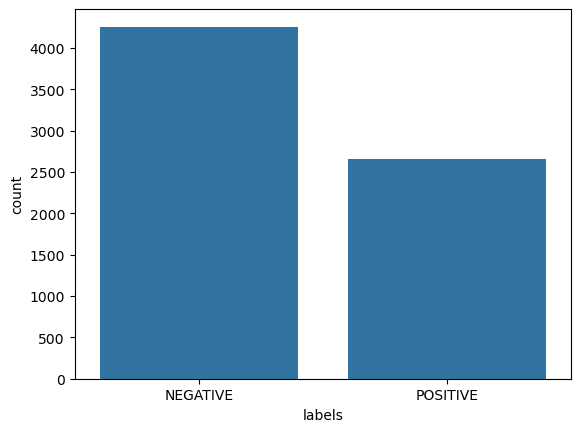

In [36]:
sns.countplot(data=data, x='labels')

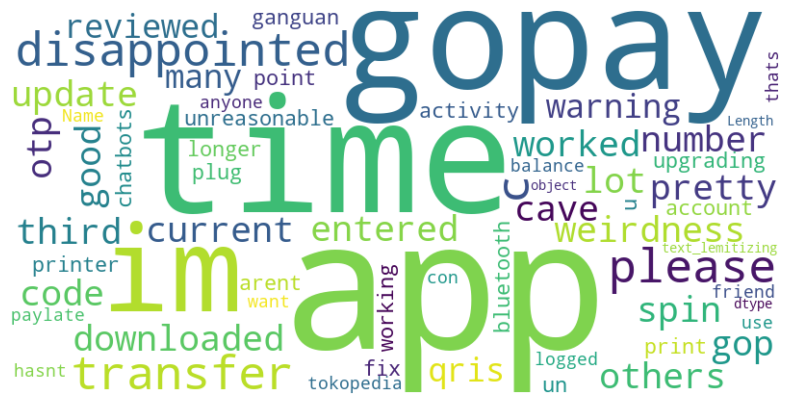

In [52]:
wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=STOPWORDS).generate(str(docs[docs['text_label']=='NEGATIVE']['text_lemitizing']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

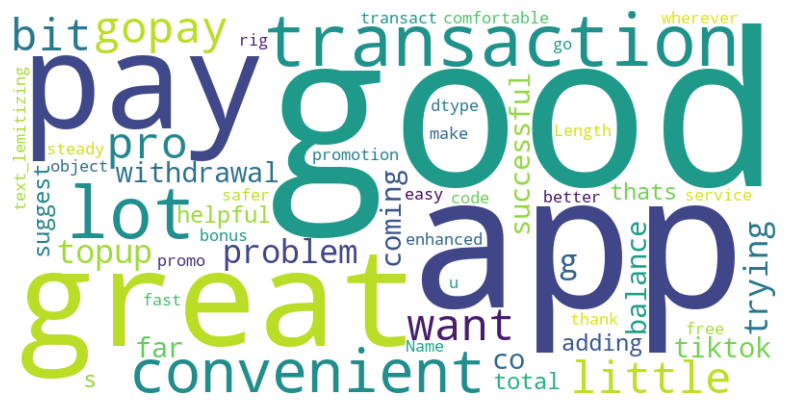

In [53]:
wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=STOPWORDS).generate(str(docs[docs['text_label']=='POSITIVE']['text_lemitizing']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<Axes: xlabel='labels', ylabel='score'>

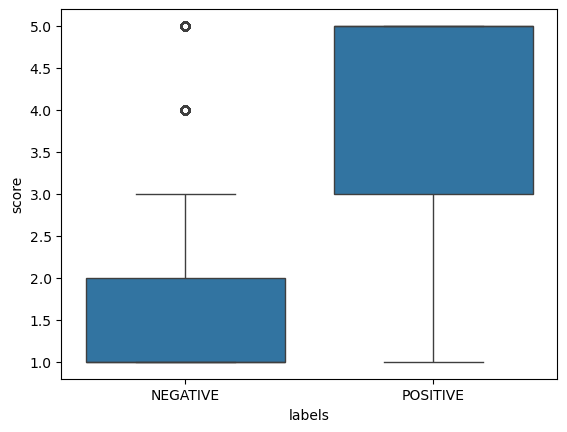

In [55]:
sns.boxplot(data=data, x='labels', y='score')

<Axes: xlabel='month', ylabel='Count'>

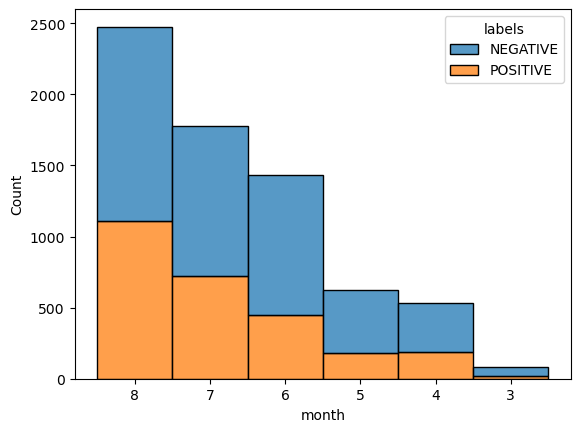

In [38]:
sns.histplot(data=data, x="month", hue="labels", multiple="stack")

<Axes: xlabel='majorVersion', ylabel='Count'>

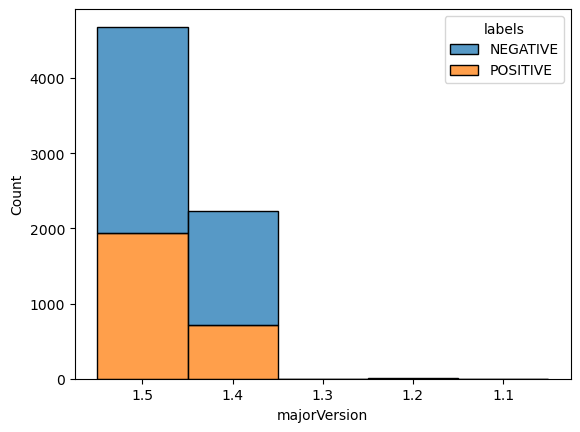

In [39]:
sns.histplot(data=data, x="majorVersion", hue="labels", multiple="stack")

# Topic Analysis

In [40]:
!pip install bertopic

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 101.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 101.3 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.40-cp312-cp312-linux_x86_64.whl size=847020 sha256=92ff2a61c2f68ea69fb417241fed78edf01ca7349fec9f3ee19bb8159f95e5ef
  Stored in directory: /home/jovyan/.cache/pip/wheels/80/e7/bb/173ca0d8ce12718c4b5e6e01619c99653579b56969b97604b2
Successfully built hdbscan
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [bertopic]3/6 [umap-learn]


In [41]:
negative = docs[docs['text_label']=='NEGATIVE']['text_lemitizing']
positive = docs[docs['text_label']=='POSITIVE']['text_lemitizing']

In [42]:
from bertopic import BERTopic
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
from sklearn.decomposition import TruncatedSVD

In [43]:
embedding_model = pipeline("feature-extraction", model="princeton-nlp/sup-simcse-roberta-large")
umap_model = TruncatedSVD(n_components=5)
vectorizer_model = CountVectorizer(min_df=10,ngram_range=(1, 3))
ctfidf_model = ClassTfidfTransformer(bm25_weighting=True)
representation_model = MaximalMarginalRelevance(diversity=0.3)

def topic(n_cluster):
    topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=AgglomerativeClustering(n_clusters=n_cluster),
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model,
    representation_model=representation_model,
    calculate_probabilities=True,
    verbose=True,
    )
    return topic_model

config.json:   0%|          | 0.00/664 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [47]:
negative_topic = topic(25)
negative_info = negative_topic.fit_transform(negative)
negative_info = negative_topic.get_topic_info()
negative_info.to_excel('negative_topic.xlsx')
negative_info

2025-08-30 08:43:41,905 - BERTopic - Embedding - Transforming documents to embeddings.
100% 4257/4257 [00:18<00:00, 236.31it/s]
2025-08-30 08:43:59,926 - BERTopic - Embedding - Completed ✓
2025-08-30 08:43:59,926 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-30 08:43:59,947 - BERTopic - Dimensionality - Completed ✓
2025-08-30 08:43:59,947 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-30 08:44:00,134 - BERTopic - Cluster - Completed ✓
2025-08-30 08:44:00,136 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-30 08:44:02,902 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,0,257,0_app_account_gopay app_phone,"[app, account, gopay app, phone, gopay account...",[little disappointed gopay app problem gopay p...
1,1,240,1_hasnt_bank_balance hasnt_yet,"[hasnt, bank, balance hasnt, yet, gopay balanc...",[clear oath im money hasnt gone gopay yet even...
2,2,223,2_cant_cant use_fails_problem,"[cant, cant use, fails, problem, app, applicat...",[ive repeatedly facial verification always fai...
3,3,213,3_problem_please fix_log_slow,"[problem, please fix, log, slow, ive waiting, ...",[overall almost feature good bad thing custome...
4,4,211,4_whats wrong_long time_cant change_dont like,"[whats wrong, long time, cant change, dont lik...",[dont know dont know dont know dont know dont ...
5,5,211,5_instead_money_transaction_buy,"[instead, money, transaction, buy, cashback, v...",[promo topup game rupee gimmick time got x wan...
6,6,209,6_delete_long time_app_gopay account,"[delete, long time, app, gopay account, phone,...",[good im going delete account im going delete ...
7,7,208,7_transfer_time_transaction_loan,"[transfer, time, transaction, loan, bank, paym...",[since there vague announcement pppatk top gop...
8,8,207,8_loan_cashback_didnt_withdraw,"[loan, cashback, didnt, withdraw, money cant, ...",[im disappointed loan ive never late even ive ...
9,9,197,9_lot bug_im trying_im sorry_email,"[lot bug, im trying, im sorry, email, day ive,...",[uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh ...


In [ ]:
negative_topic.set_topic_labels({
    1: "Space Travel", 7: "Religion"
})

In [ ]:
negative_topic.merge_topics(negative, 
                            [1,2,3],
                            [4,5,6])

In [ ]:
negative_info = negative_topic.get_topic_info()
negative_info

In [48]:
positive_topic = topic(12)
positive_info = positive_topic.fit_transform(positive)
positive_info = positive_topic.get_topic_info()
positive_info.to_excel('positive_topic.xlsx')
positive_info

2025-08-30 08:45:51,776 - BERTopic - Embedding - Transforming documents to embeddings.
100% 2663/2663 [00:10<00:00, 252.75it/s]
2025-08-30 08:46:02,321 - BERTopic - Embedding - Completed ✓
2025-08-30 08:46:02,321 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-30 08:46:02,332 - BERTopic - Dimensionality - Completed ✓
2025-08-30 08:46:02,333 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-30 08:46:02,407 - BERTopic - Cluster - Completed ✓
2025-08-30 08:46:02,409 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-30 08:46:03,744 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,0,364,0_balance_game_min_pay,"[balance, game, min, pay, want, good, free, tr...","[really cool top game like top fund, really go..."
1,1,305,1_easy_quick_transaction_easier,"[easy, quick, transaction, easier, cheap, easy...","[transaction cheap fast easy, quick easy pay e..."
2,2,281,2_im_balance_fix_problem,"[im, balance, fix, problem, better, hope, stea...",[whats matter gopay yeah im toping balance bca...
3,3,271,3_app_helpful_gopay_free,"[app, helpful, gopay, free, cheap, feature, ap...",[really like gopay transaction app cheap helpf...
4,4,266,4_transaction_pay_always_saving,"[transaction, pay, always, saving, thank, gopa...","[time top balance balance go balance sheet, iv..."
5,5,238,5_transfer_app_easier_free,"[transfer, app, easier, free, convenient, easy...",[gopay feature easy make transaction like puls...
6,6,195,6_better_helpful_apk_feature,"[better, helpful, apk, feature, nice, sometime...",[please please please please please please ple...
7,7,173,7_cant_problem_app_want,"[cant, problem, app, want, time, fix, gopay, t...",[gopay emng there problem simple practical the...
8,8,173,8_free_transfer_game_cheap,"[free, transfer, game, cheap, topup, gopay, ma...",[love five star special first transaction get ...
9,9,168,9_easy use_practical_helpful_easier,"[easy use, practical, helpful, easier, satisfy...","[easy use helpful, simple easy use, good easy ..."


In [ ]:
positive_topic.set_topic_labels({
    1: "Space Travel", 7: "Religion"
})

In [ ]:
positive_topic.merge_topics(positive, 
                           [[1,2],
                           [3,4]]
                           )

positive_info = positive_topic.get_topic_info()
positive_info

# Conclusion